In [1]:
from encoder import Encoder2 as E
from ffnn import FFNN
import matplotlib.pyplot as plt
import torch
import numpy as np
from data_loader import CustomSignalData
from helpers1 import get_data, get_tensor, clf_acc, rotate_batch, get_all_data, get_data1, get_operators
import pandas as pd

# Import test data

In [2]:
kRMS = [0]*12
for idx, i in enumerate([0,1,3,4,6,7,9,10,12,13,15,16]):
    kRMS[idx] = pd.read_csv('window_RMS_kinetic_{}.csv'.format(i))
    
kRMS_test = [0]*6
for idx, i in enumerate([8,11,14,17, 2,5]):
    kRMS_test[idx] = pd.read_csv('window_RMS_kinetic_{}.csv'.format(i))

In [3]:
X_train, y_train = get_data(0, 1, kRMS, 12,0)
_, y_test = get_data(0,0, kRMS_test, 6,0)

all_X_train, all_X0_train, all_y_train, all_shift_train = get_all_data(X_train, y_train, kRMS)
#all_X_test, all_X0_test, all_y_test, all_shift_test = get_all_data(X_test, y_test, kRMS_test)
#all_X0_train.shape, all_X0_test.shape

In [4]:
X_test = get_data1(0,0, kRMS_test, 6)
X_test.shape

(1993, 8, 24)

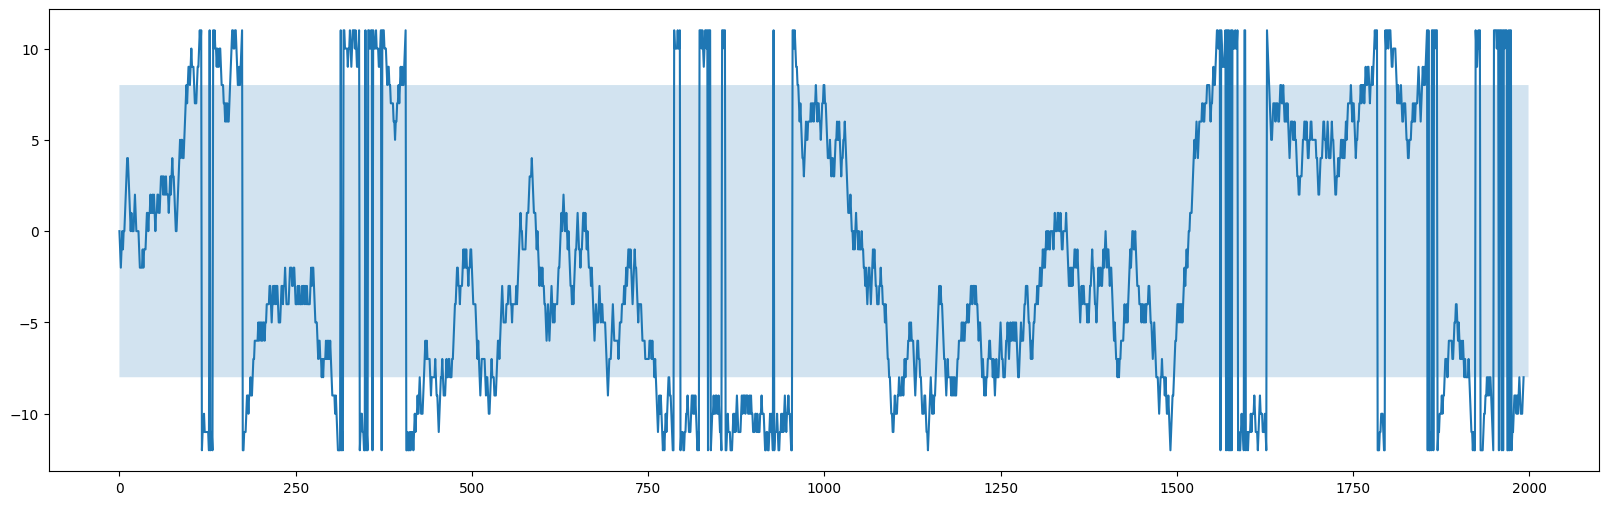

In [452]:
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=100)
np.random.seed(100)
movements_ = np.random.randint(-1,2, size=X_test.shape[0])
movements_sum_ = (movements_.cumsum()+12 - movements_[0])%24-12

X_test_ = np.zeros([X_test.shape[0],192])
for idx_mv_, mv_ in enumerate(movements_sum_):
    X_test_[idx_mv_] = np.roll(X_test[idx_mv_,:,:], mv_, 1).reshape(-1,192)
    
plt.plot(movements_sum_)
plt.fill_between(range(2000), -8,8, alpha=0.2)


# FFNN with Operator

In [8]:
def rotate_all(x, real_):
    rotated = torch.empty(x.shape[0], 3*6)
    for idx_i,i in enumerate(range(real_-1,real_+2)):
        d = -torch.ones(x.shape[0])*i
        rotated[:, 6*idx_i:6*idx_i+6] = (ffnn_with_op.classifer[0](ffnn_with_op.encoder(rotate_batch(x, d.int(), 6))))
    return rotated

## Import trained models

In [588]:
inputDim = 192     # takes variable 'x' 
outputDim = 6      # takes variable 'y'

ffnn_with_op = FFNN(inputDim, outputDim)
encoder = E(inputDim, inputDim)

ffnn_with_op.load_state_dict(torch.load('FFNN_with_operator2.pt'))
encoder.load_state_dict(torch.load('encoder2.pt'))

<All keys matched successfully>

## Calculate centroids

In [589]:
with torch.no_grad():
    encoder.eval()
    N_points = 1000
    rand_idx = np.random.choice(all_X_train.shape[0], N_points)
    y_tr = encoder(get_tensor(all_X_train[rand_idx]))
    recovered_points_ = rotate_batch(y_tr,-all_shift_train[rand_idx].flatten(), 6)
    del y_tr

In [590]:
used_bases, phi1 = get_operators(192, 24)

## Calculate performance

In [ ]:
inferred_deg = []
with torch.no_grad():
    for i in range (-15, 16):
        X_test_shift,y_test_shift = get_data(0,0, kRMS_test, 6,i)
        y_tr = encoder(get_tensor(X_test_shift) )
        y_tr_rotated = rotate_all(y_tr).repeat(6,1,1)
        distance_to_centroid = torch.empty(31*6, y_tr.shape[0])
        for j in range(6):
            slice_distort = slice(31*j,31*(j+1))
            distance_to_centroid[slice_distort] = ((y_tr_rotated[slice_distort]- centroids[j])**2).mean(2)
        min_dist = distance_to_centroid.argmin(0) % 31
        inferred_deg.append((min_dist*1.0).mean().int().abs().item() % 24)

### Predicted translation degree

In [591]:
with torch.no_grad():
    pred_shift = [0]
    pred_class = []
    curr_shift = 0

    for samm in X_test_:

        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1)) )
        y_tr_rotated = rotate_all(y_tr, (curr_shift+12)%24-12).argmax()
        pred_class.append(y_tr_rotated%6)
        #curr_shift = (curr_shift+12)%24-12
        curr_shift += y_tr_rotated//6-1
        
        pred_shift.append(y_tr_rotated//6-1)
    print(1-(1+torch.tensor(pred_class)[:] - y_test.flatten()[:]).count_nonzero()/X_test_[:].shape[0]) 
    del y_tr_rotated
    del y_tr
    

tensor(0.6081)


In [592]:
with torch.no_grad():
    pred_shift = [6]
    pred_class = []
    curr_shift = 6
    pred_shiftt = [curr_shift]
    
    for samm in X_test_:
       
        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1))).flatten()
        distances = np.zeros(3)
        for i, d in enumerate(range(curr_shift-1,curr_shift+2)):
            x_rotated = used_bases[d].matmul(y_tr).repeat(N_points,1)
            distances[i] = ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
        y_tr_rotated = distances.argmin()-1
        
        curr_shift = (curr_shift+12)%24-12
        curr_shift += y_tr_rotated
        chosen_x = ffnn_with_op(used_bases[curr_shift].matmul(y_tr)).argmax()
        pred_class.append(chosen_x)
        
        pred_shiftt.append(-curr_shift)
        pred_shift.append(-y_tr_rotated)
    print(1-(1+torch.tensor(pred_class)[:] - y_test.flatten()[:]).count_nonzero()/X_test_[:].shape[0]) 
    del y_tr_rotated
    del y_tr
    

tensor(0.6999)


In [593]:
1-np.count_nonzero(movements_- pred_shift[1:])/1993


0.6181635725037632

In [594]:
def get_distances(d,y_tr):
    x_rotated = used_bases[d].matmul(y_tr).repeat(N_points,1)
    return ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()

with torch.no_grad():
    pred_class = []
    curr_shift = 0
    pred_shift = []
    pred_shiftt = []
    for samm in X_test_:
        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1))).flatten()
        #distances = np.zeros(25)
        #with Parallel(n_jobs=-1,) as parallel:
            # Iterate CEM
            #distances = parallel(delayed(get_distances)(d, y_tr) for d in range(-12,13))
        distances = [(get_distances)(d, y_tr) for d in range(-12,13)]
        y_tr_rotated = -(np.array(distances).argmin()-12)
        curr_shift = (y_tr_rotated+12)%24-12
        
        chosen_x = ffnn_with_op(used_bases[-curr_shift].matmul(y_tr)).argmax()
        pred_class.append(chosen_x)
        pred_shiftt.append(curr_shift)
        pred_shift.append(y_tr_rotated)
        
    print(1-(1+torch.tensor(pred_class)[:] - y_test.flatten()[:]).count_nonzero()/X_test_[:].shape[0]) 
    del y_tr_rotated
    del y_tr
    

tensor(0.7155)


In [595]:
with torch.no_grad():
    #y_tr_rotateds = movements_sum_ + np.random.normal(0, 5, 1993)
    #y_tr_rotateds[0] = 5
    #y_tr_rotateds[np.random.choice(1993, 100)] += 5
    pred_shift = [0]
    pred_class = [ffnn_with_op(encoder(get_tensor(X_test_[0].astype('float32')))).argmax()]
    curr_shift = 0
    pred_shiftt = [curr_shift]
    ks = []
    p = 0
    x= 0
    K= 0

    Q = 2/3
    R = 1
    for index_iter in range(1,1993):
        samm = X_test_[index_iter]
        x_pred = x
        p_pred = p+ Q
        K = p_pred / (p_pred + R)
        ks.append(K)
        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1))).flatten()
        distances = np.zeros(25)
        for i, d in enumerate(range(-12,13)):
            x_rotated = used_bases[d].matmul(y_tr).repeat(N_points,1)
            distances[i] = ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
        y_tr_rotated = -(distances.argmin()-12)
        #y_tr_rotated = y_tr_rotateds[index_iter]
        x =  K* (y_tr_rotated -x_pred) + x_pred #- (x_pred-12)%24 -12
        x = round(x)
        curr_shift = x
        p = (1-K) * p_pred
        ks.append(K)
        #curr_shift += y_tr_rotated
        curr_shift = (curr_shift+12)%24-12
        
        chosen_x = ffnn_with_op(used_bases[-round(curr_shift)].matmul(y_tr)).argmax()
        pred_class.append(chosen_x)
        
        pred_shiftt.append(curr_shift)
        pred_shift.append(y_tr_rotated)
    print(1-(1+torch.tensor(pred_class)[:] - y_test.flatten()[:]).count_nonzero()/X_test_[:].shape[0]) 
    del y_tr_rotated
    del y_tr
    

tensor(0.6954)


In [616]:
from scipy.stats import t

with torch.no_grad():

    noise_std = 0.5
    degrees_of_freedom = 1

    def measurement_likelihood(measurement, particles, degrees_of_freedom):
        likelihoods = t.pdf( -particles + measurement, loc=0, scale=noise_std, df=degrees_of_freedom)
        return likelihoods

    motion_model=lambda x: x + np.random.randint(-1,2, x.shape)

    pred_shift = [0]
    pred_class = [ffnn_with_op(encoder(get_tensor(X_test_[0].astype('float32')))).argmax()]

    curr_shift = 0
    pred_shiftt = [curr_shift]

    num_particles = 5000
    weights = np.ones(num_particles) / num_particles
    particles = np.random.randint(-1,2, size=num_particles)
    xs = [0]
    x= 0

    for index_iter in range(1,1993):
        samm = X_test_[index_iter]
        particles = motion_model(particles)

        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1))).flatten()
        distances = np.zeros(25)
        for i, d in enumerate(range(-12,13)):
            x_rotated = used_bases[d].matmul(y_tr).repeat(N_points,1)
            distances[i] = ((x_rotated-recovered_points_)**2).mean(1).topk(10, largest=False)[0].mean()
        y_tr_rotated = -(distances.argmin()-12)

        weights = measurement_likelihood(y_tr_rotated-((x+12)%24 -12) +x, particles, degrees_of_freedom)
        weights /= np.sum(weights) # Normalize weights

        # Resampling Step
        indices = np.random.choice(range(num_particles), size=num_particles, replace=True, p=weights.flatten())
        particles = particles[indices]
        weights = np.ones(num_particles) / num_particles

        # State estimation
        estimated_state = np.average(particles, axis=0, weights=weights)
        
        x = estimated_state

        curr_shift = (round(x)+12)%24-12
        chosen_x = ffnn_with_op(used_bases[-round(curr_shift)].matmul(y_tr)).argmax()
        pred_class.append(chosen_x)
        
        pred_shiftt.append(curr_shift)
    print(1-(1+torch.tensor(pred_class)[:] - y_test.flatten()[:]).count_nonzero()/X_test_[:].shape[0]) 
    del y_tr_rotated
    del y_tr
    

tensor(0.7160)


In [255]:
np.array(pred_shift) - np.array([0] + pred_shift[:-1])

array([ 0, -2, -1, ..., -1,  5,  0])

In [ ]:
plt.plot(pred_shiftt)
plt.plot((np.array(pred_shift).cumsum()+12)%24-12)

In [ ]:
(torch.tensor(pred_class[1328:])+1 -y_test[1328:].flatten())[150:]

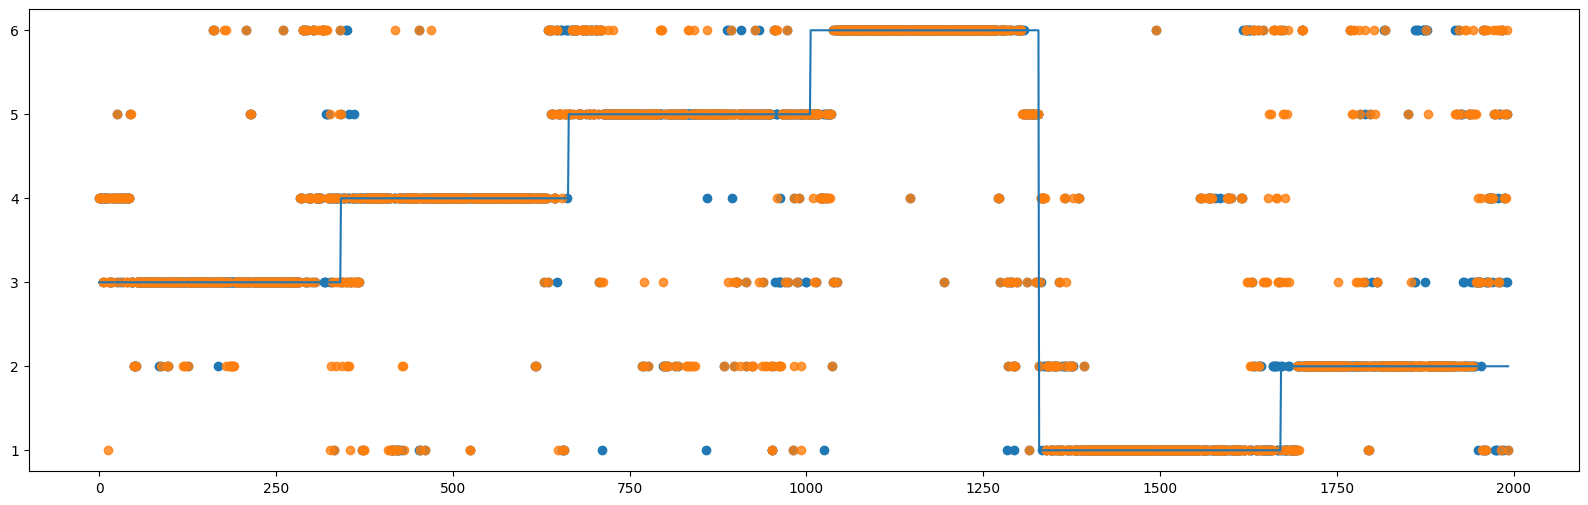

In [620]:
figure(figsize=(20, 6), dpi=100)
plt.scatter(x= range(len(pred_class_)), y=np.array(pred_class_[:])+1)
plt.scatter(x= range(len(pred_class)), y=np.array(pred_class[:])+1, alpha=0.8)

plt.plot()
plt.plot(y_test[:])

1.5609633718013045


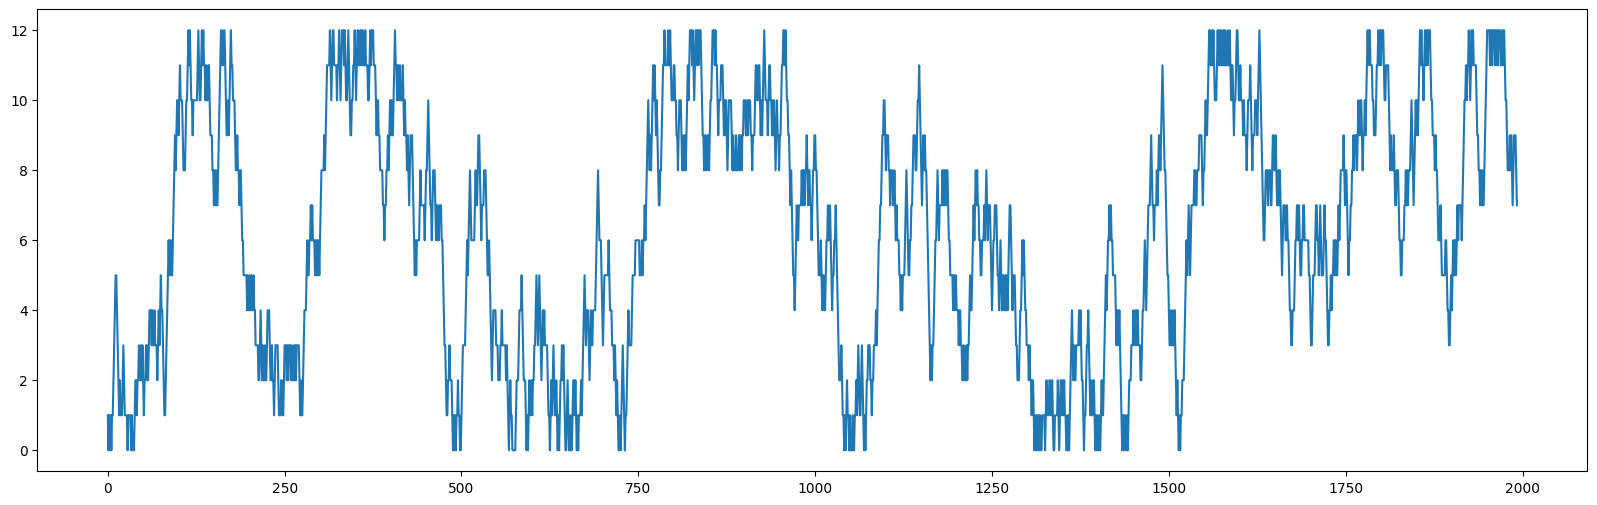

In [609]:
figure(figsize=(20, 6), dpi=100)
#plt.plot(((np.array(pred_shiftt)[:-1]+12-movements_sum_[:])%24-12))

plt.plot(np.abs(((np.array(pred_shiftt)[1]+12-movements_sum_[:])%24-12)))
print(np.abs(((np.array(pred_shiftt)[:]+12-movements_sum_[:])%24-12)).mean())

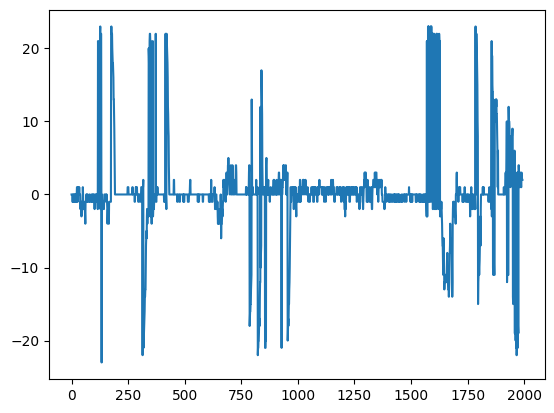

In [599]:
plt.plot(np.array(pred_shiftt)[:] - movements_sum_[:])

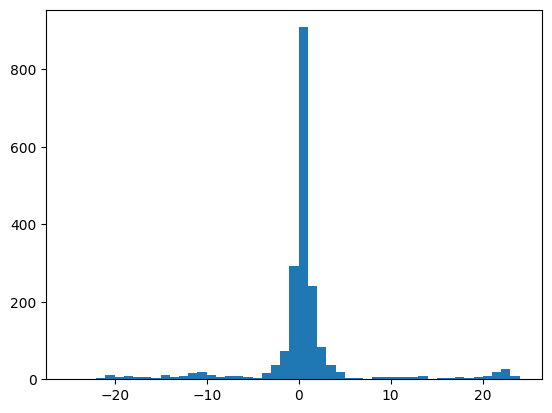

In [600]:
plt.hist(torch.tensor(np.array(pred_shiftt)[:] - movements_sum_[:]), bins=range(-25,25))
plt.show()

In [297]:
1-torch.tensor((np.array(pred_shiftt)[:]+12-movements_sum_[:])%24-12).count_nonzero()/1993

tensor(0.5038)

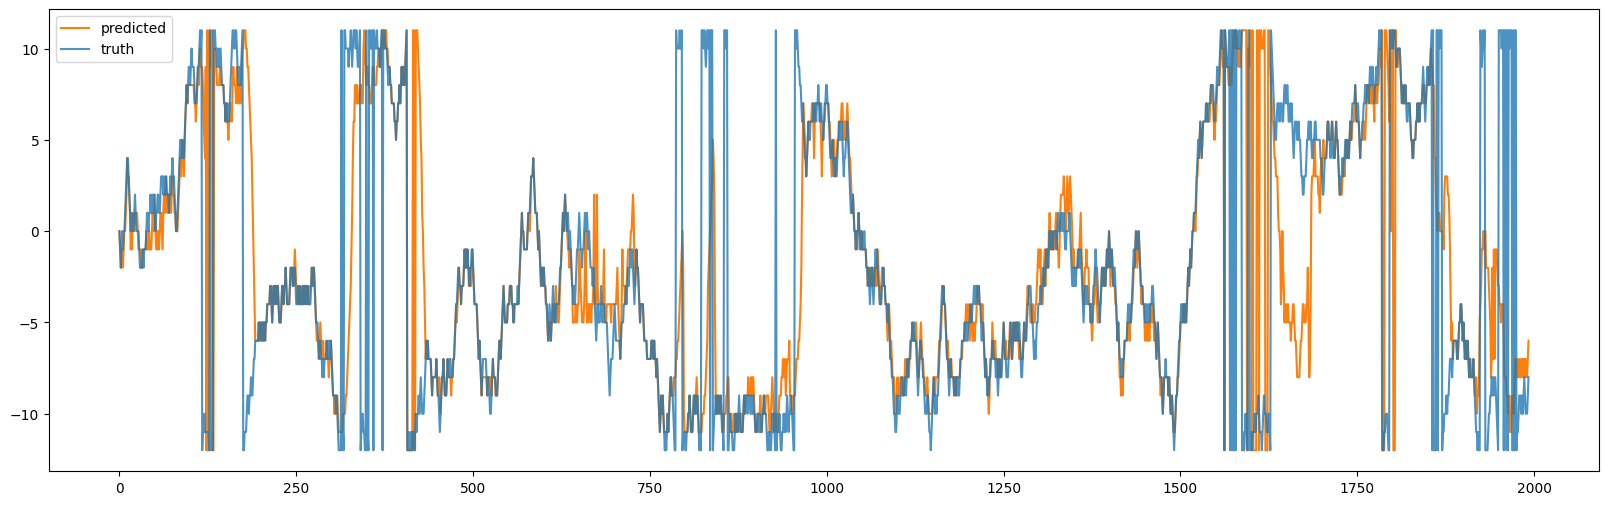

In [610]:
figure(figsize=(20, 6), dpi=100)
pred_shiftt= np.array(pred_shiftt)
pred_shiftt[pred_shiftt>11]= pred_shiftt[pred_shiftt>11]

plt.plot(range(1993),pred_shiftt[:], label='predicted', c='#ff7f0e')
plt.plot(range(1993),movements_sum_[:], c='#1f77b4', label='truth', alpha=0.8)

plt.legend()

In [ ]:
plt.plot(range(-12,13),pred_shift,'-o')
plt.fill_between(range(-8,9), 0,1, alpha=0.2)

### Labelled translation degree

In [36]:
accuracies_self_supervised_ = []
for i in range (-15, 16):
    X_test_shift,y_test_shift = get_data(0,0, kRMS_test, 6,i)
    y_tr = encoder(get_tensor(X_test_shift) )
    y_tr_rotated = rotate_batch(y_tr,- torch.ones(y_tr.shape[0]).int()*i, 6)
    distt = torch.zeros(X_test_shift.shape[0], 6)
    for i in range(6):
        distt[:, i] = ((y_tr_rotated-centroids[i])**2).mean(1)
    min_dist = distt.argmin(1)
    accuracies_self_supervised_.append(1-(1+min_dist - y_test_shift.flatten()).count_nonzero()/y_tr.shape[0]) 
del y_tr_rotated
del y_tr

In [80]:
accuracies_self_supervised__ = []
for i in range (-12, 13):
    X_test_shift,y_test_shift = get_data(0,0, kRMS_test, 6,i)
    y_tr = encoder(get_tensor(X_test_shift) )
    y_tr_rotated = rotate_batch(y_tr,- torch.ones(y_tr.shape[0]).int()*(i), 6)
    
    min_dist = torch.argmax(ffnn_with_op(y_tr_rotated),1)
    accuracies_self_supervised__.append(1-(1+min_dist - y_test_shift.flatten()).count_nonzero()/y_tr.shape[0]) 
del y_tr

In [615]:
with torch.no_grad():
    pred_class_ = []
    for mvvv, samm in zip(movements_sum_,X_test_):
        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1)) )
        y_tr_rotated = ffnn_with_op(rotate_batch(y_tr,- torch.ones(y_tr.shape[0]).int()*(mvvv), 6)).argmax()
        pred_class_.append(y_tr_rotated%6)
    print(1-(1+torch.tensor(pred_class_) - y_test.flatten()).count_nonzero()/X_test_.shape[0]) 
    del y_tr_rotated
    del y_tr
    

tensor(0.7556)


In [611]:
with torch.no_grad():
    pred_class = []
    pred_shift = []
    for mvvv, samm in zip(movements_sum_,X_test_):
        y_tr = encoder(get_tensor(samm.astype('float32').reshape(1,-1)) ).flatten()
        distances = torch.zeros(3)
        for i, d in enumerate(range(-mvvv-1,-mvvv+2)):
            x_rotated = used_bases[d].matmul(y_tr).repeat(N_points,1)
            distances[i] = ((x_rotated-recovered_points_)**2).mean(1).topk(2, largest=False)[0].mean()
        y_tr_rotated = distances.argmin()
        chosen_x = ffnn_with_op(used_bases[-mvvv].matmul(y_tr)).argmax()
        pred_class.append(chosen_x)
        pred_shift.append(1-(mvvv-y_tr_rotated*1.0).sign().abs().mean())
    print(1-(1+torch.tensor(pred_class) - y_test.flatten()).count_nonzero()/X_test_.shape[0]) 
    print(np.mean(pred_shift))
    del y_tr_rotated
    del y_tr
    

tensor(0.7556)
0.029603614


# Compare models

In [ ]:
#plt.plot(range(-12,13),accuracies_ffnn_with_all, '-s', label="Supervised")
plt.plot(range(-12,13),accuracies_self_supervised__, '-o', label="Self-supervised, w. operator")
#plt.plot(range(-15,16),accuracies_self_supervised_, '-o', label="Self-supervised, w. operator")

#plt.plot(range(-12,13),accuracies_self_supervised, '-o', label="Self-supervised, w. auto operator")

plt.legend()
plt.fill_between(range(-8,9), 0,1, alpha=0.2)

In [ ]:
accuracies_self_supervised